In [58]:
%matplotlib inline

In [59]:
import mne
import pathlib
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("minimal.mplstyle")
mne.viz.set_browser_backend("matplotlib")

'matplotlib'

In [60]:
RAW_DATA_PATH = pathlib.Path("../data/EEG")

SESSION = "group13_own"

In [61]:
raw = mne.io.read_raw_brainvision(
    vhdr_fname = RAW_DATA_PATH.joinpath(SESSION + ".vhdr"),
    eog = ("HEOG", "VEOG"),
    misc = ("41",),
    preload = True,
    verbose = False
)

raw.set_montage(
    mne.channels.make_standard_montage("standard_1020"), 
    verbose=False
)

raw.info

C:\Users\dl\AppData\Local\Temp\ipykernel_12912\4173104079.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 30 EEG, 2 EOG, 1 misc
 custom_ref_applied: False
 dig: 33 items (3 Cardinal, 30 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2024-02-28 14:02:50 UTC
 nchan: 33
 projs: []
 sfreq: 1000.0 Hz
>

In [62]:
PLOT_SETTINGS = dict(
    n_channels=len(raw.ch_names),
    scalings=dict(
        eeg = 5e-5,
        misc = 2
    ),
)

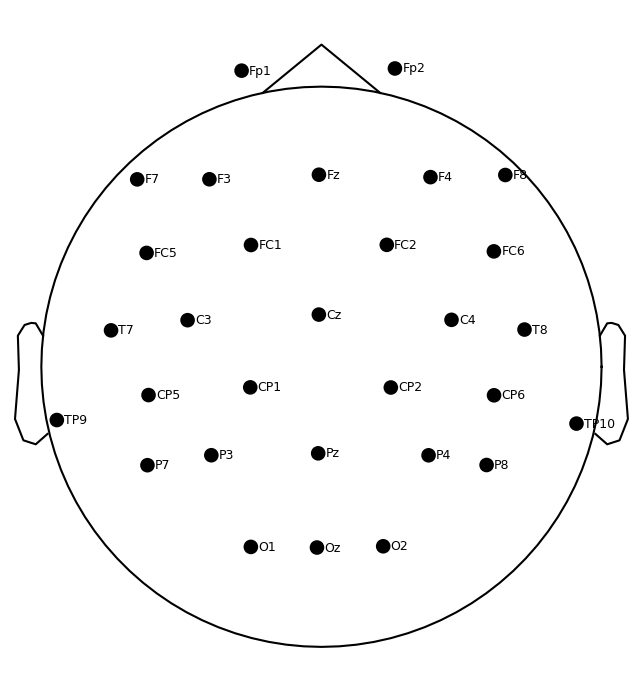

In [63]:
raw.plot_sensors(show_names = True);

Effective window size : 2.048 (s)


c:\Users\dl\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


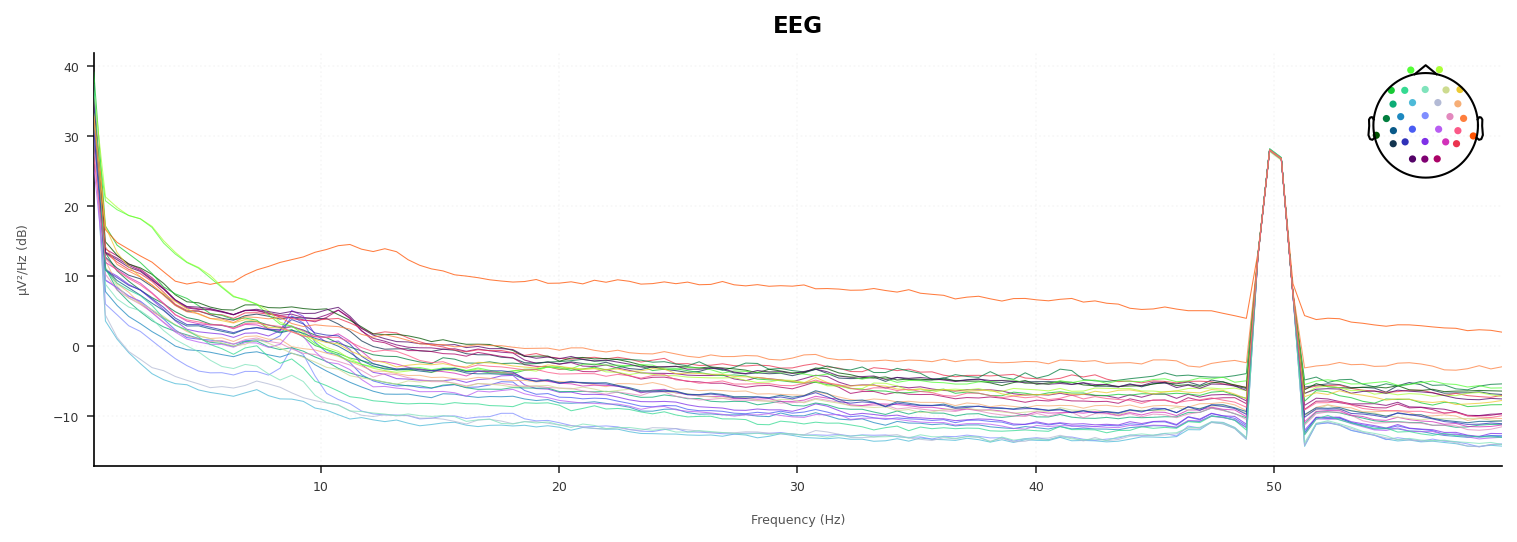

In [64]:
raw.compute_psd(
    fmin=0.01, 
    fmax=60,
    remove_dc=False
).plot();

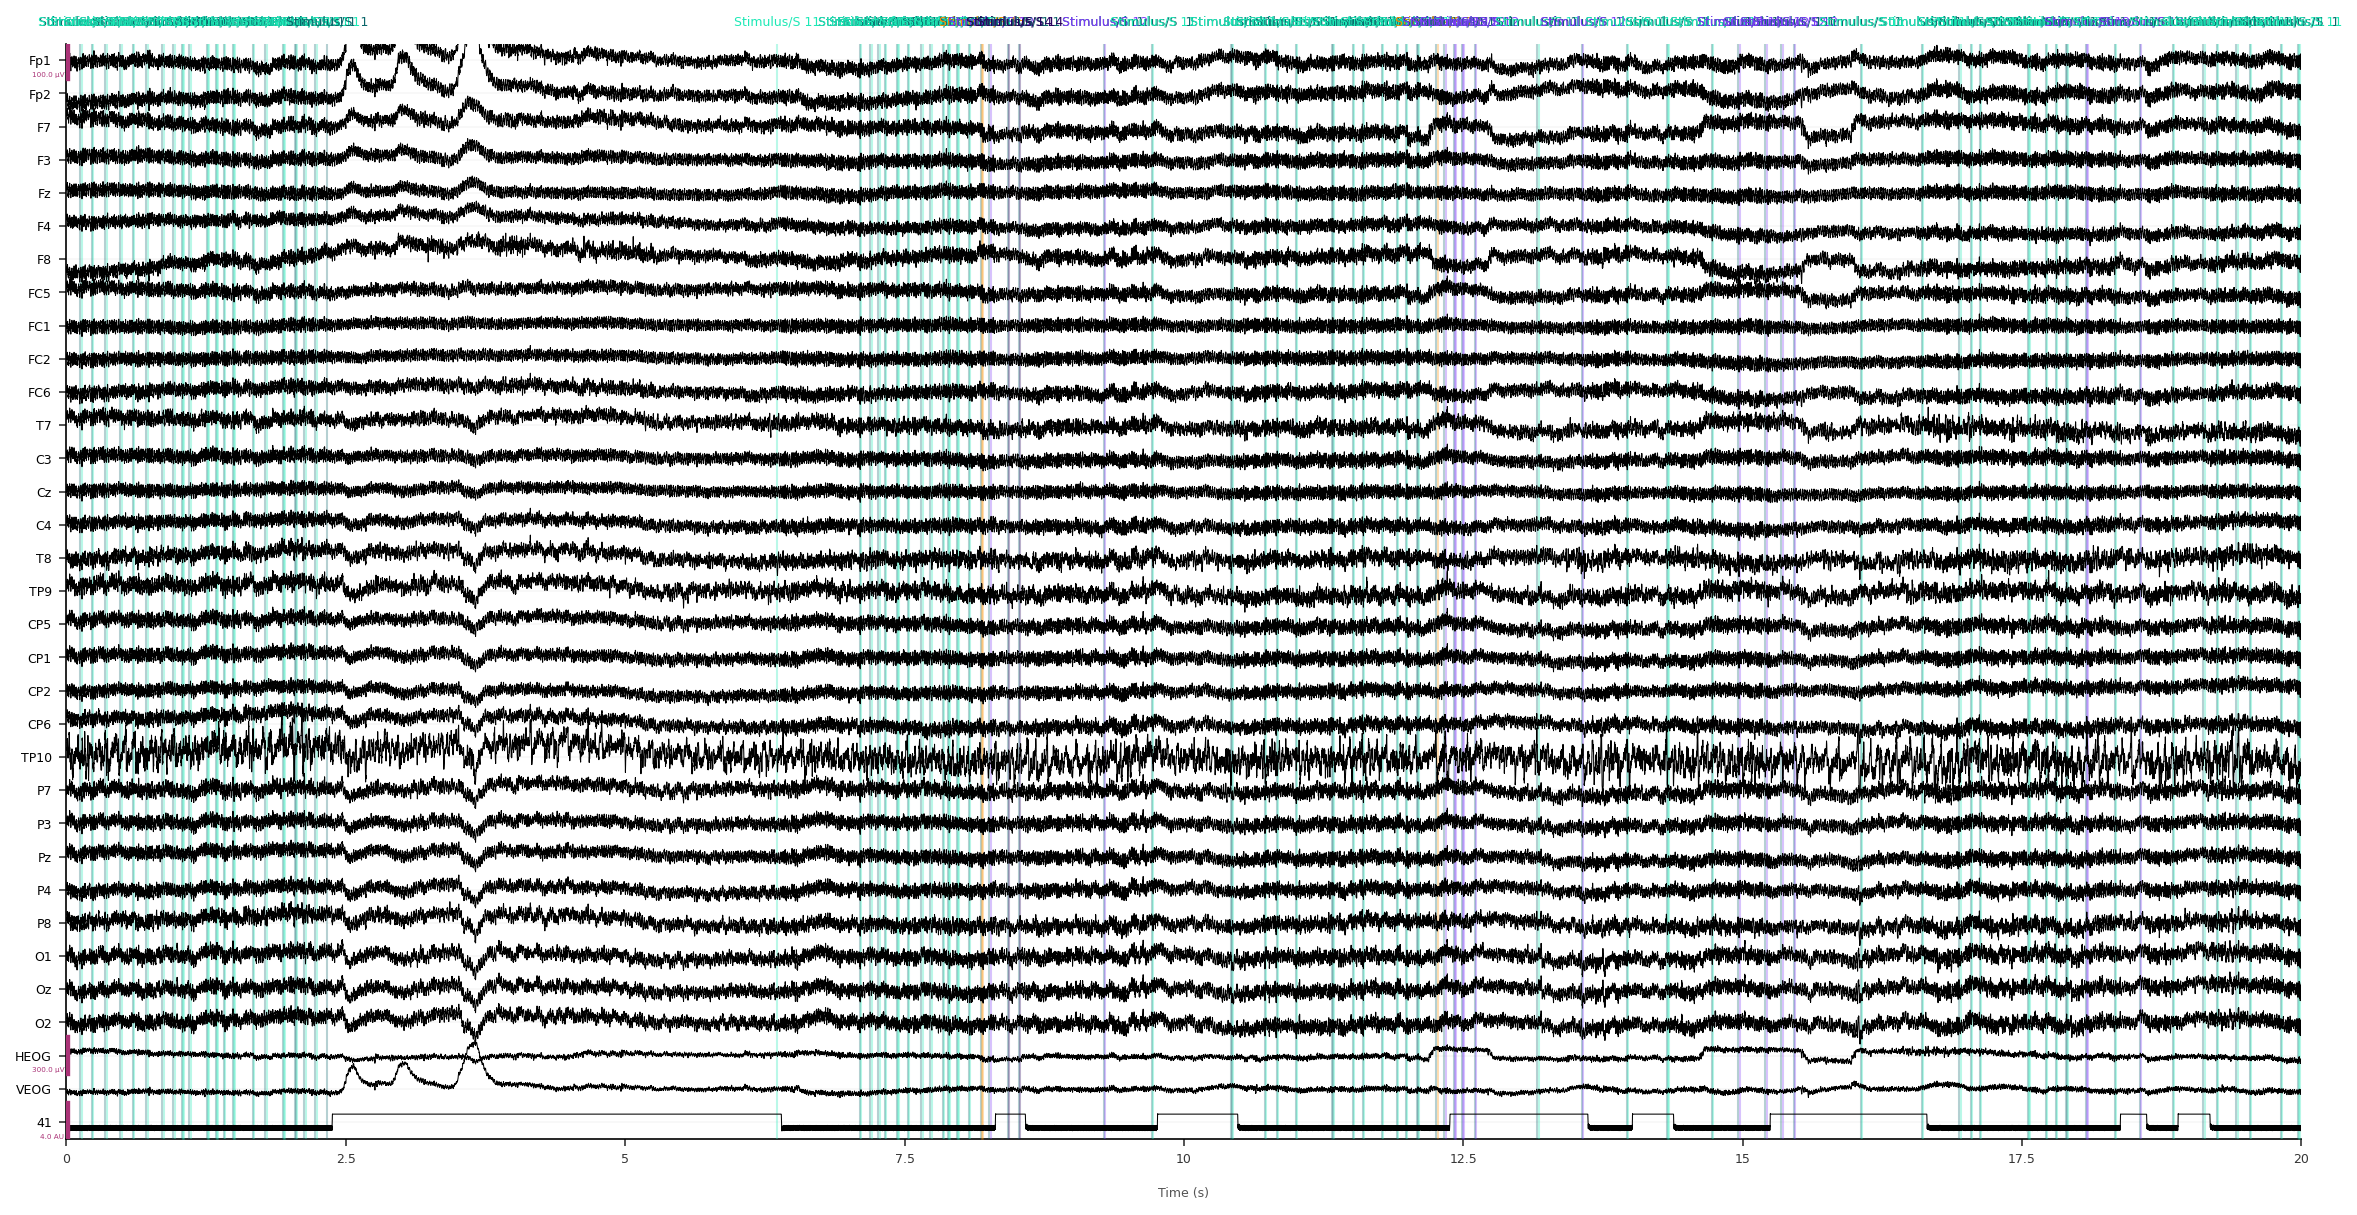

In [65]:
preview_segmentation = dict(
    begin = 90,
    end = 110
)

raw_preview_segment = raw.copy().crop(
    tmin = preview_segmentation["begin"],
    tmax = preview_segmentation["end"],
)
raw_preview_segment.plot(
    start = 0,
    duration = preview_segmentation["end"] - preview_segmentation["begin"],
    title = f"""Raw preview ({preview_segmentation["begin"]}s to {preview_segmentation["end"]}s)""",
    show_scrollbars = False,
    **PLOT_SETTINGS
);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


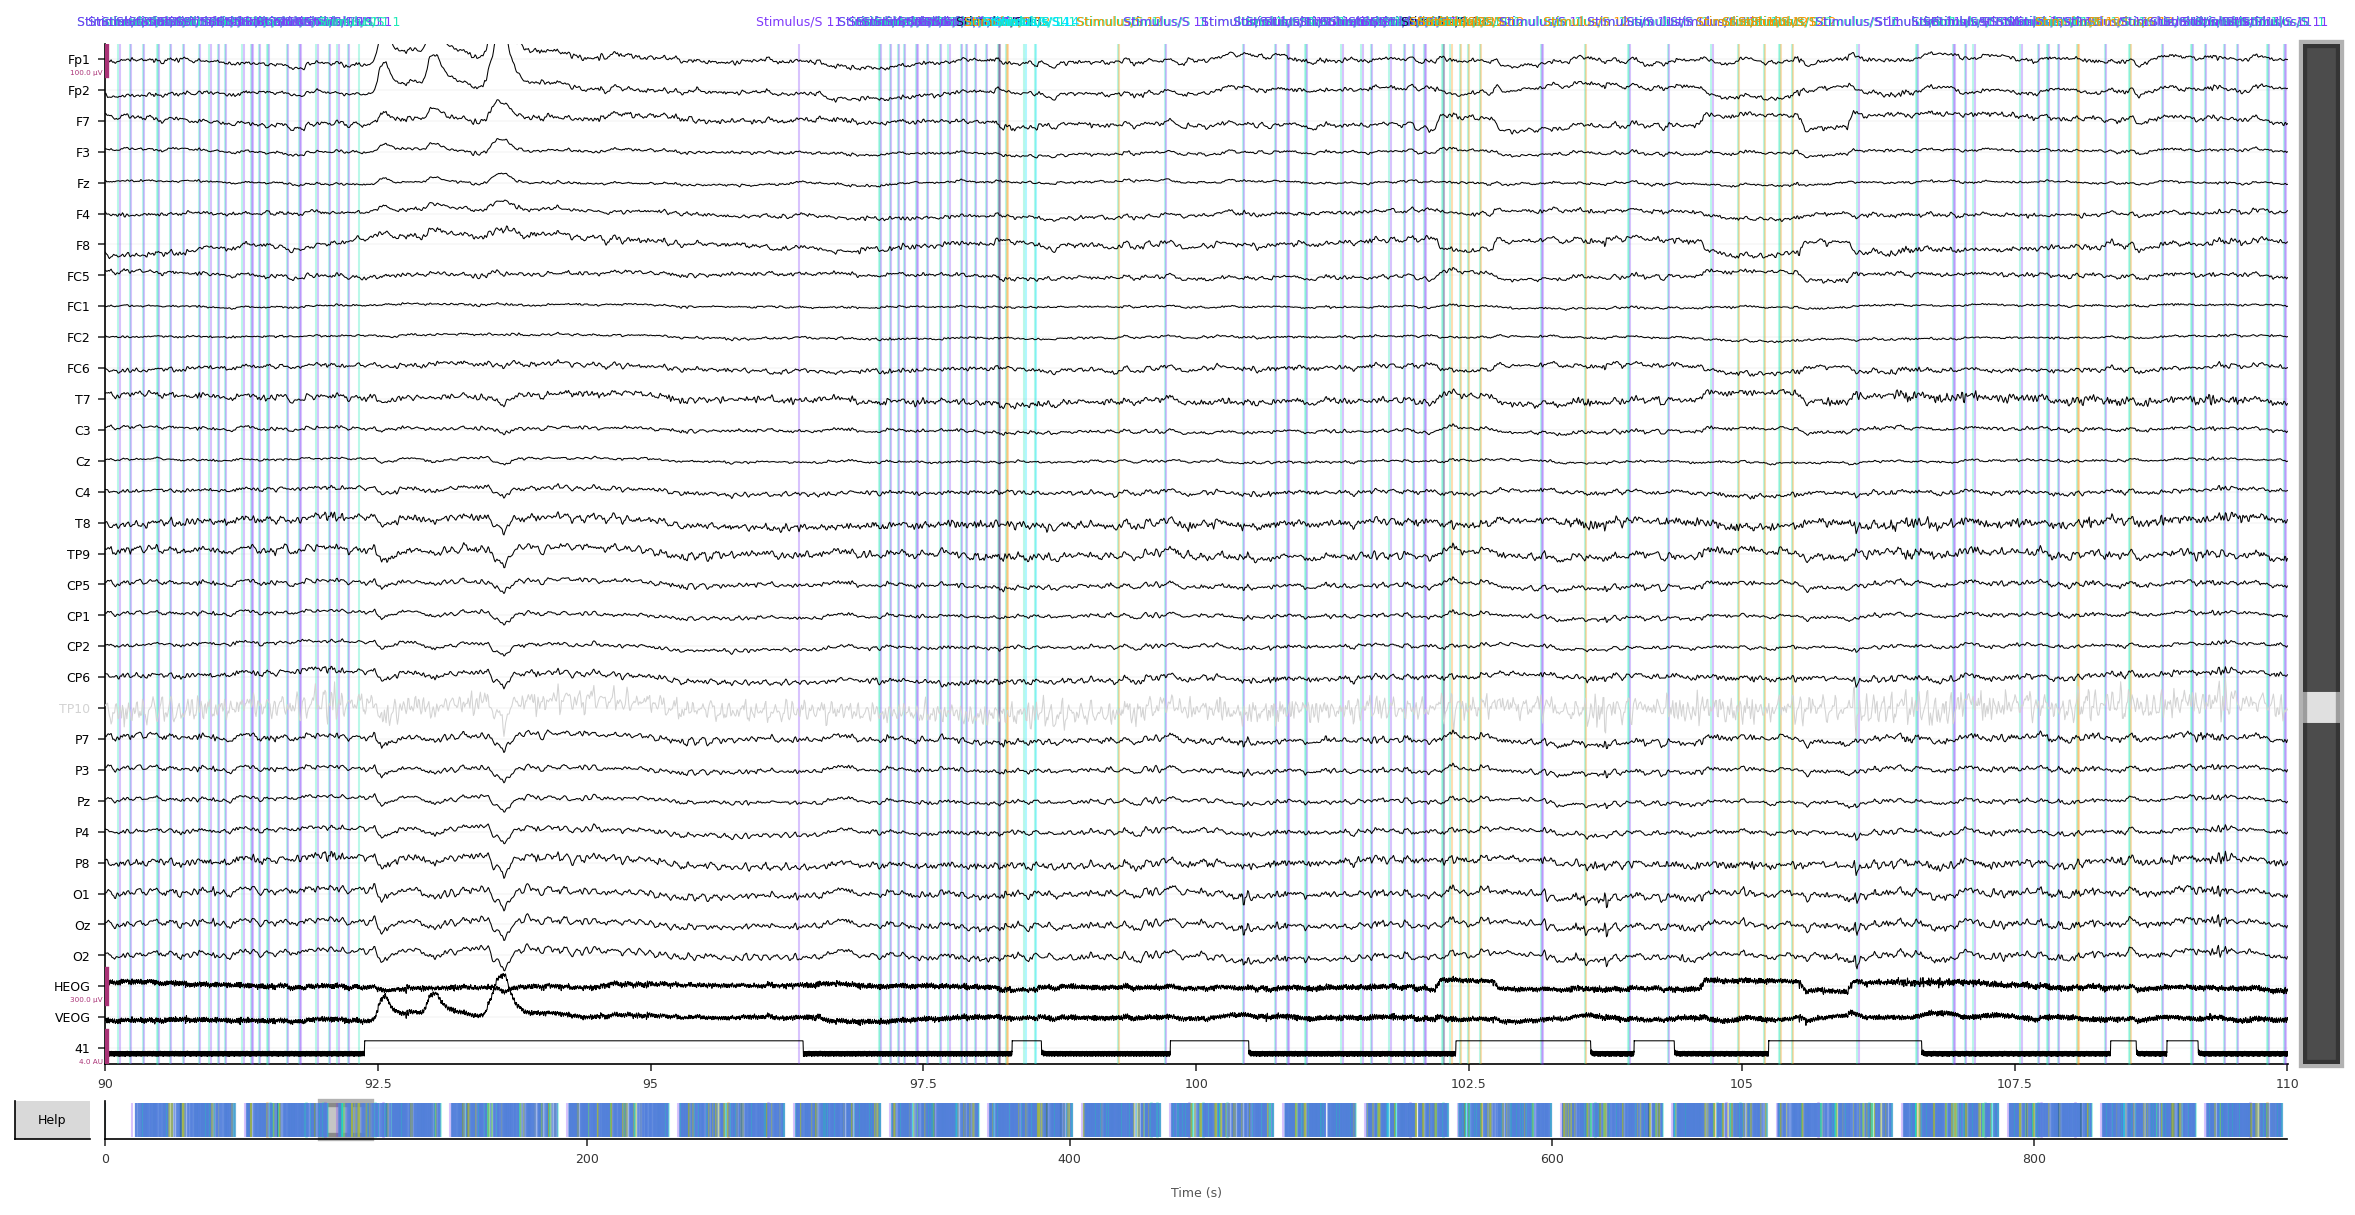

In [66]:
raw.filter(
    l_freq = 0.1, # pass everything over _ Hz
    h_freq = 40, # pass everything below _ Hz
)

raw.info["bads"] = [
    # "CP6",
    # "F4",
    # "FC6",
    # "F8",
    # "T7",
    # "T8",
    # "TP9",
    "TP10",
    # "P7",
    # "P8"
]

raw.pick(
    picks=raw.ch_names, 
    exclude="bads"
)

raw.plot(
    start = preview_segmentation["begin"],
    duration = preview_segmentation["end"] - preview_segmentation["begin"],
    **PLOT_SETTINGS
);

Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by explained variance: 10 components
Fitting ICA took 10.5s.


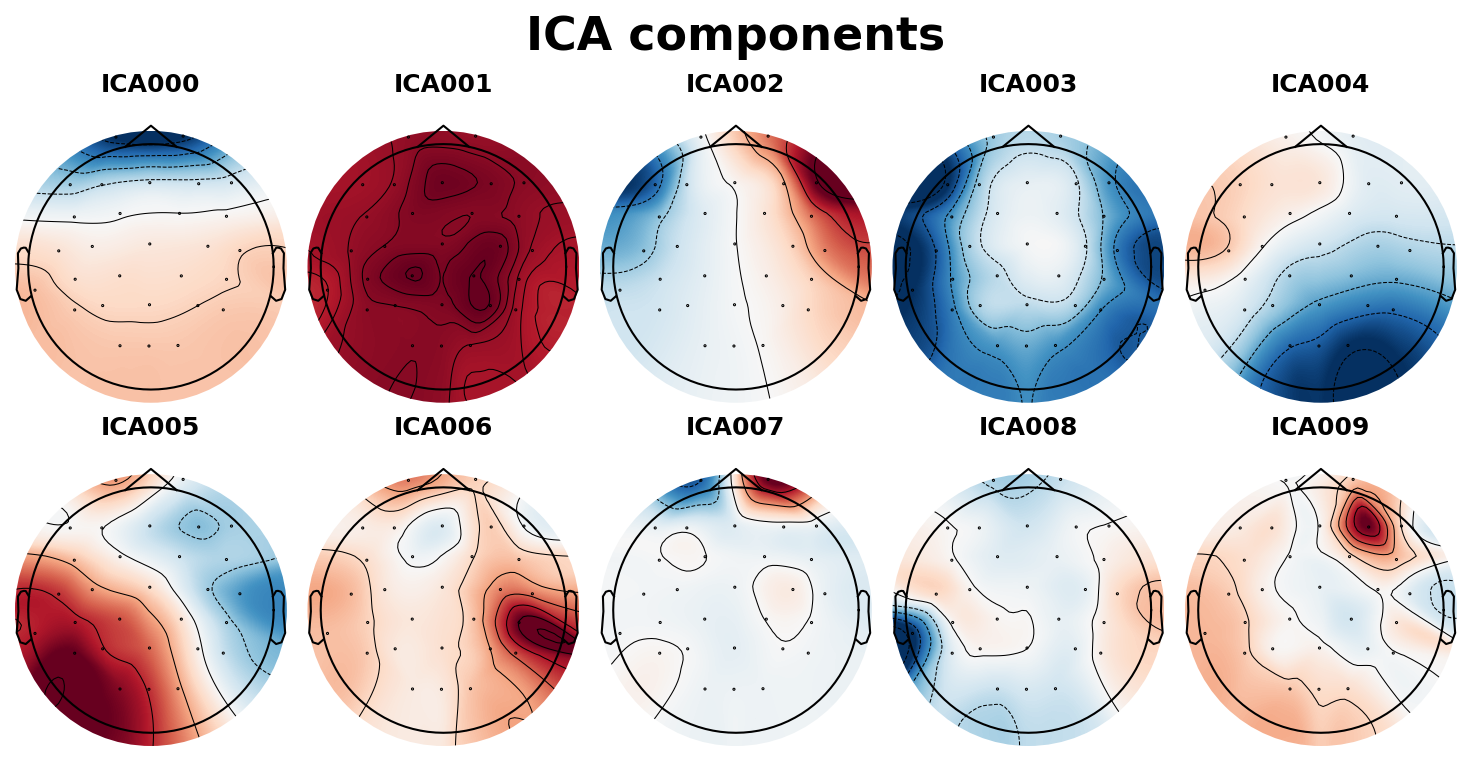

Creating RawArray with float64 data, n_channels=12, n_times=904900
    Range : 0 ... 904899 =      0.000 ...   904.899 secs
Ready.


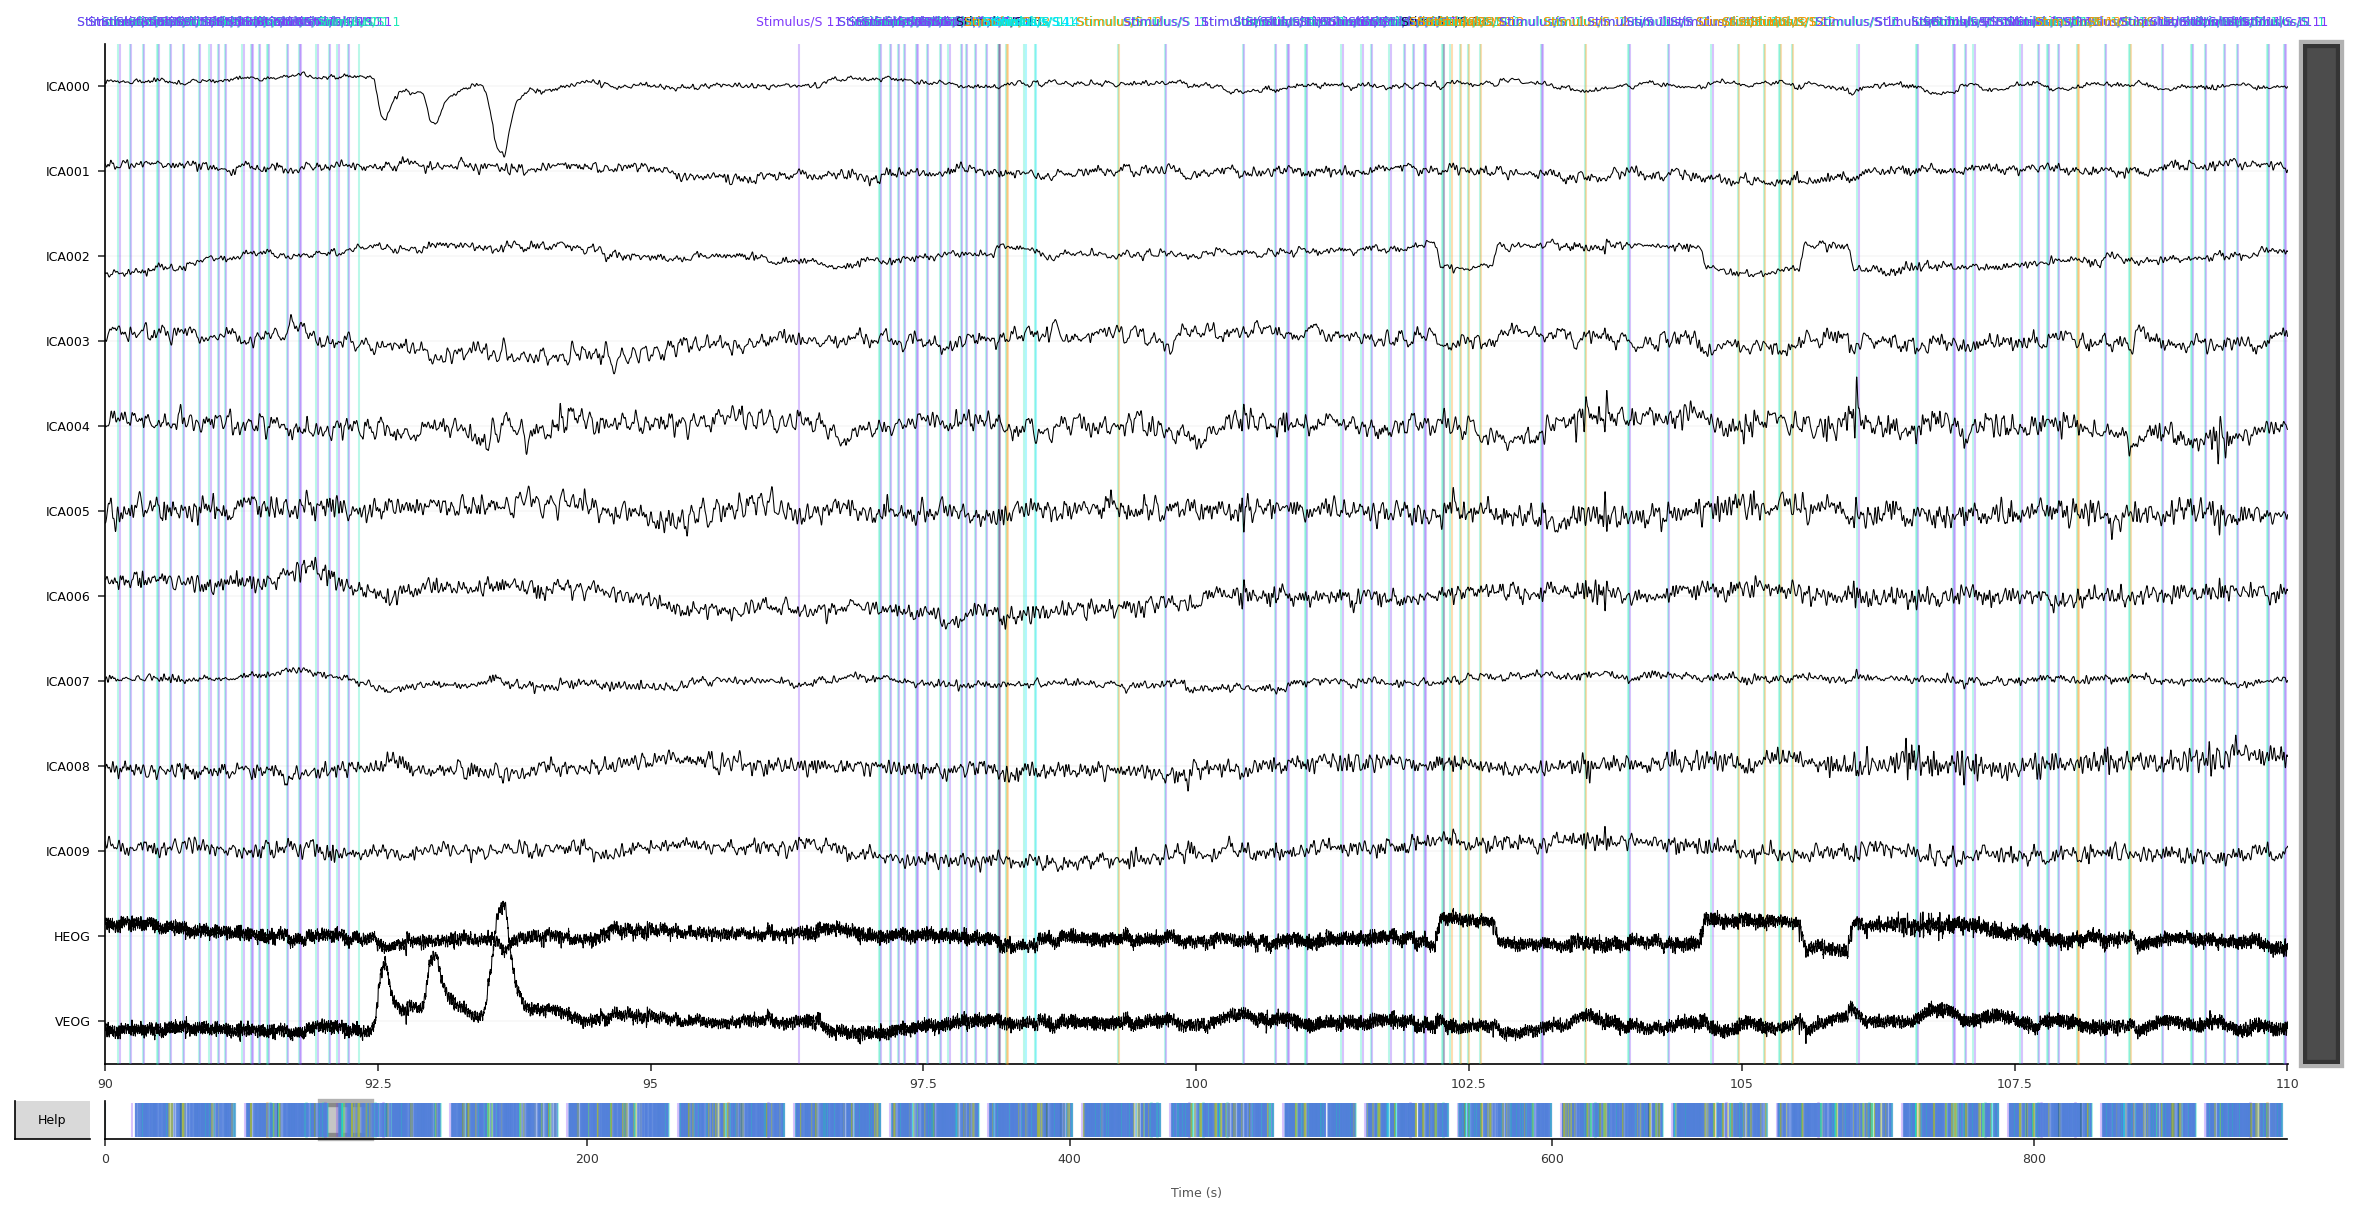

In [67]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=7, max_iter=800)
ica.fit(raw)
ica.plot_components();
ica.plot_sources(
    raw,
    start = preview_segmentation["begin"],
    stop = preview_segmentation["end"],
);

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 29 PCA components


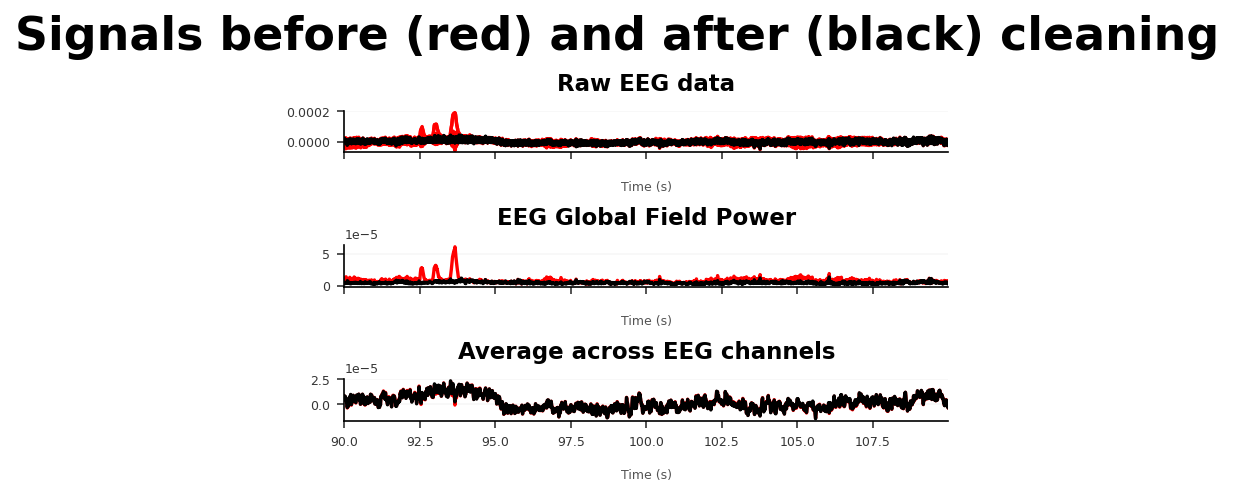

In [68]:
ica.plot_overlay(
    raw, 
    exclude=[0, 2],
    start = preview_segmentation["begin"] * 1000,
    stop = preview_segmentation["end"] * 1000,
);

In [69]:
ica.exclude = [0, 2]
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 29 PCA components


<RawBrainVision | group13_own.eeg, 33 x 904900 (904.9 s), ~227.9 MB, data loaded>

In [70]:
raw.set_eeg_reference(
    "average", 
    projection=False, 
    verbose=False
)

<RawBrainVision | group13_own.eeg, 33 x 904900 (904.9 s), ~227.9 MB, data loaded>

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']


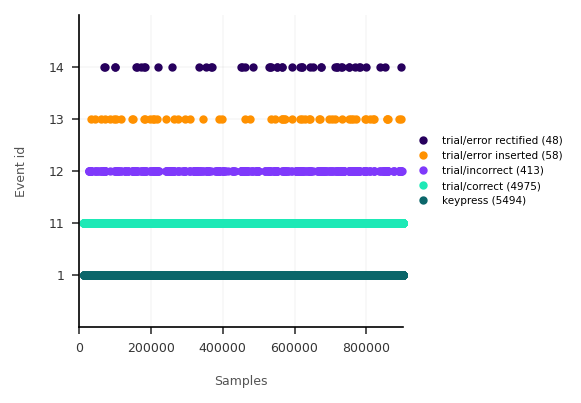

In [145]:
import sys
sys.path.append("..")
from constants import EEG_EVENT_ENCODINGS

events, event_ids = mne.events_from_annotations(raw)

mne.viz.plot_events(
    events, 
    event_id = EEG_EVENT_ENCODINGS,
    color = dict(),
    on_missing = "ignore",
    show = True,
    verbose = "ERROR"
);

In [72]:
epochs = mne.Epochs(
    raw, 
    events,
    event_id = EEG_EVENT_ENCODINGS, 
    reject = dict(eeg = 150e-6), 
    tmin = -0.2, 
    tmax = 0.6,
    baseline = (-0.2, 0),
    preload = True,
    verbose = False
)
epochs.info

<Info | 10 non-empty values
 bads: 1 items (TP10)
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 30 EEG, 2 EOG, 1 misc
 custom_ref_applied: True
 dig: 33 items (3 Cardinal, 30 EEG)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2024-02-28 14:02:50 UTC
 nchan: 33
 projs: []
 sfreq: 1000.0 Hz
>

In [73]:
print(f"{len([ep for ep in epochs.drop_log if len(ep)]) / len(events):.1%} of epochs were dropped")

0.0% of epochs were dropped


In [74]:
# epochs.resample(sfreq=200)

No projector specified for this dataset. Please consider the method self.add_proj.


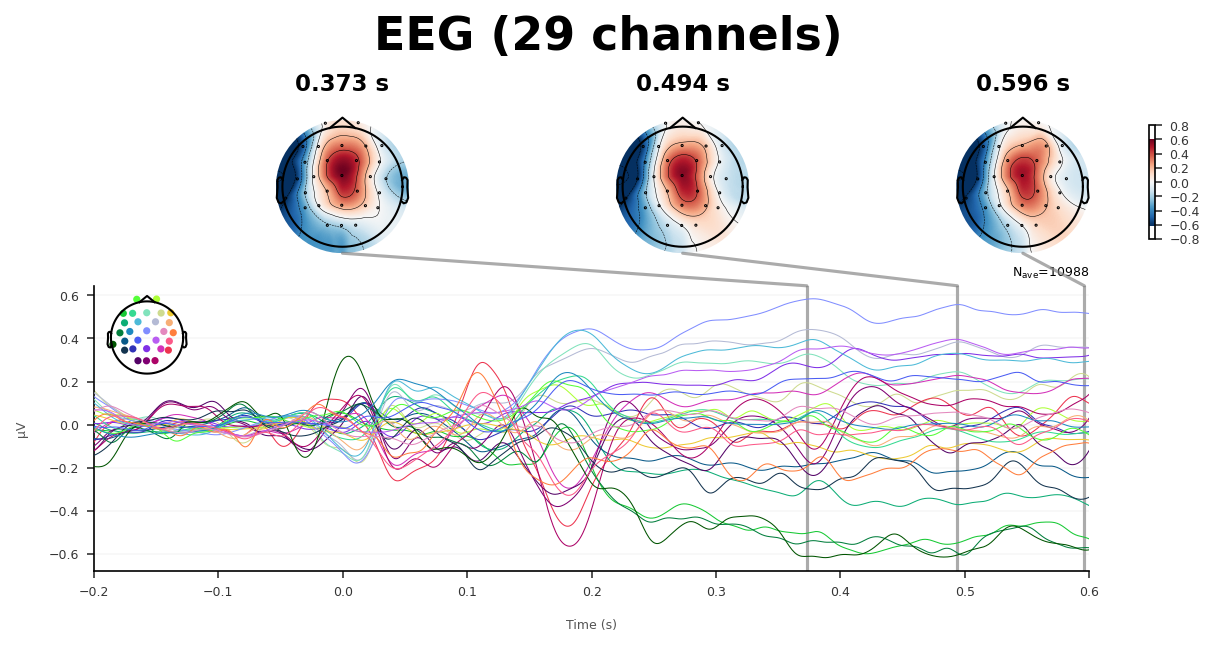

In [75]:
epochs.average(picks = "eeg").plot_joint();

Not setting metadata
5023 matching events found
No baseline correction applied
0 projection items activated


C:\Users\dl\AppData\Local\Temp\ipykernel_12912\2787221005.py:2: RuntimeWarning: Only one channel in group "O2"; cannot combine by method "mean".
  epochs[events].plot_image(


combining channels using "mean"


C:\Users\dl\AppData\Local\Temp\ipykernel_12912\2787221005.py:2: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  epochs[events].plot_image(


KeyboardInterrupt: 

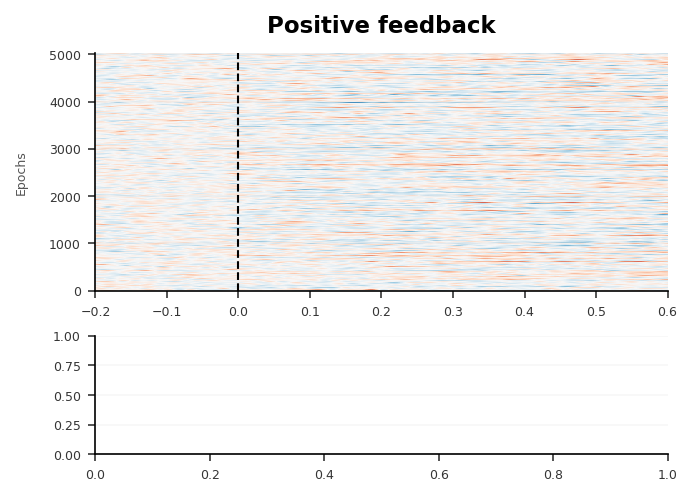

In [142]:
for condition, events in zip(("Positive feedback", "Negative feedback"), [["correct", "error rectified"], ["incorrect", "error inserted"]]):
    epochs[events].plot_image(
        picks = ["O2"],
        title = condition,
)[0];

Not setting metadata
471 matching events found
No baseline correction applied
0 projection items activated


C:\Users\dl\AppData\Local\Temp\ipykernel_12912\4214499463.py:5: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.2 s and 0.6 s)
  epochs[["incorrect", "error inserted"]].plot_image(


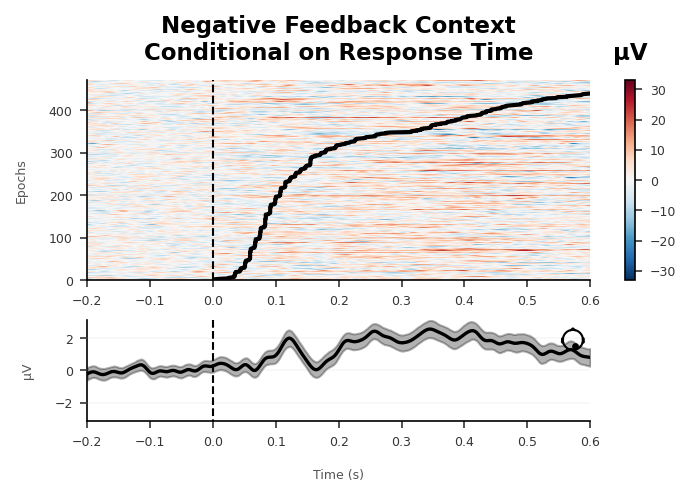

In [148]:
negative_feedback_trials = np.where(np.isin(events[:,2], (12, 13)))[0]
response_times = events[negative_feedback_trials + 1][:-1,0] - events[negative_feedback_trials][:-1,0]
response_times = np.append(response_times, np.median(response_times))

epochs[["incorrect", "error inserted"]].plot_image(
    picks = ["O2"],
    title = "Negative Feedback Context\nConditional on Response Time",
    overlay_times = np.divide(response_times, 1000),
    order = np.argsort(response_times),
)[0];

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


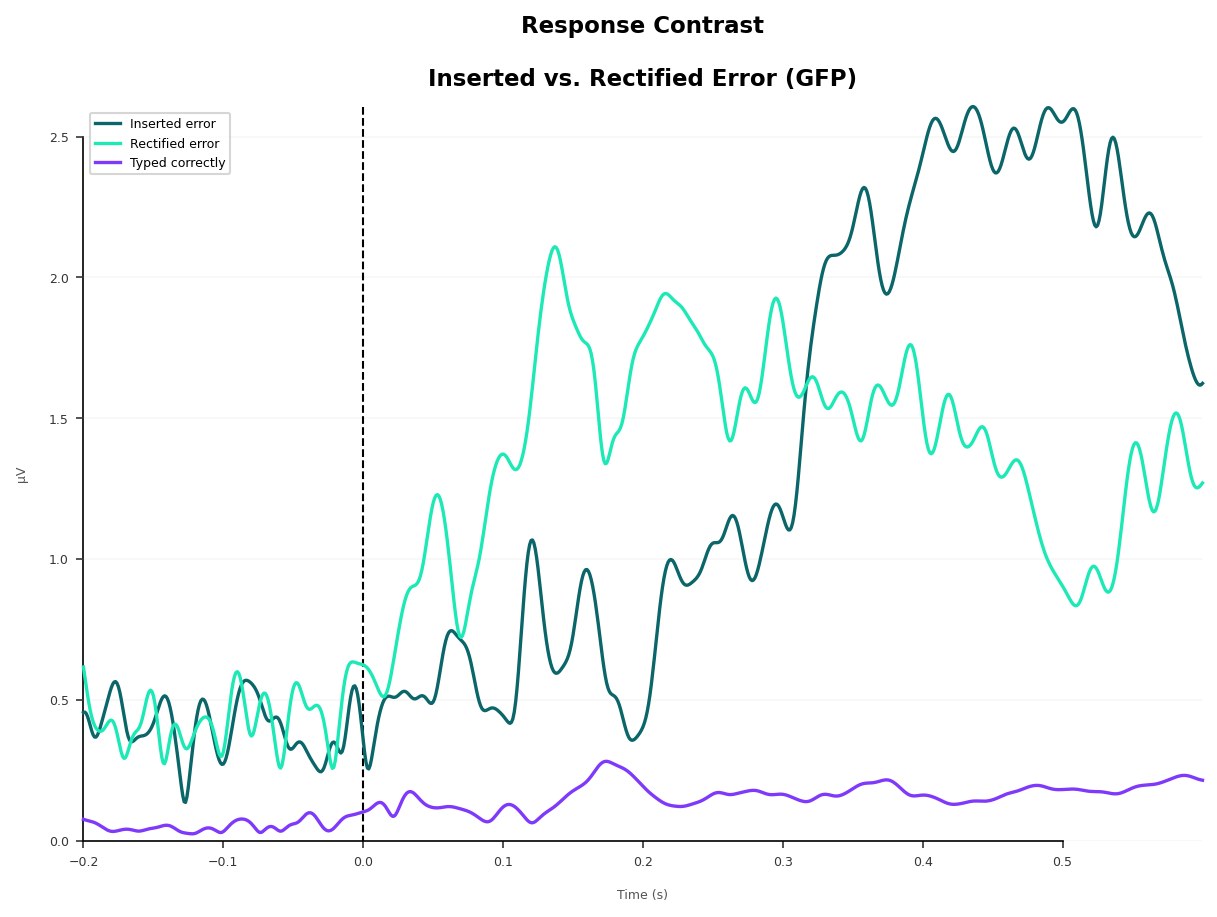

In [77]:
mne.viz.plot_compare_evokeds(
    evokeds={
        "Inserted error"    : epochs["error inserted"].average(),
        "Rectified error"   : epochs["error rectified"].average(),
        "Typed correctly"   : epochs["correct"].average(),
    }, 
    ci = 0.95,
    title = "Response Contrast\n\nInserted vs. Rectified Error"
)[0];